# Home assignment

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A home assignment from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

## Problem statement

The dataset we are interested in here is called "TwoPatterns". It is described [in this page](http://www.timeseriesclassification.com/description.php?Dataset=TwoPatterns) and can be downloaded using `tslearn`'s `load_dataset` utility, as seen in previous labs.

You should load the data and analyze it under several angles:

1. visualize the dataset (or a few time series from the dataset) to understand whether you expect time-shift-invariant methods to perform well on this dataset or not ;
2. compare time-shift-invariant methods to their time-shift-sensitive counterparts for the following tasks, and conclude:
    * clustering ;
    * supervised classification ;
    * forecasting (suppose you have to forecast the second half of the series with the first half provided as input).

It is not asked here that you implement specific layers / methods by yourself, but rather that you use established implementations of the methods you need.
Your focus should rather be on:
* data visualization,
* model architecture (for deep networks),
* experiment design,
* result analysis

## Deadline

Deadline for this home assignment is February 23th, 2024.
You should use the link on moodle to hand in your assignment.
A single ipynb file should be provided,
with execution traces.
This assignment is to be done **by groups of two, at most** and names of both students should be included in the file name.

# Section 1 Data Visualization

### Load the data and show the dimensions

In [2]:
from tslearn.datasets import UCR_UEA_datasets
from keras.utils import to_categorical

X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("TwoPatterns")
#print(X_train.shape)

y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)
print(f"X_train shape: {X_train.shape}, y_train.shape: {y_train.shape}, y_train_cat.shape: {y_train_cat.shape}, y_test_cat.shape: {y_test_cat.shape}")

num_categories = y_train_cat.shape[-1]

X_train shape: (1000, 128, 1), y_train.shape: (1000,), y_train_cat.shape: (1000, 4), y_test_cat.shape: (4000, 4)


### Plot a selection of time series for each class, together with the subplots

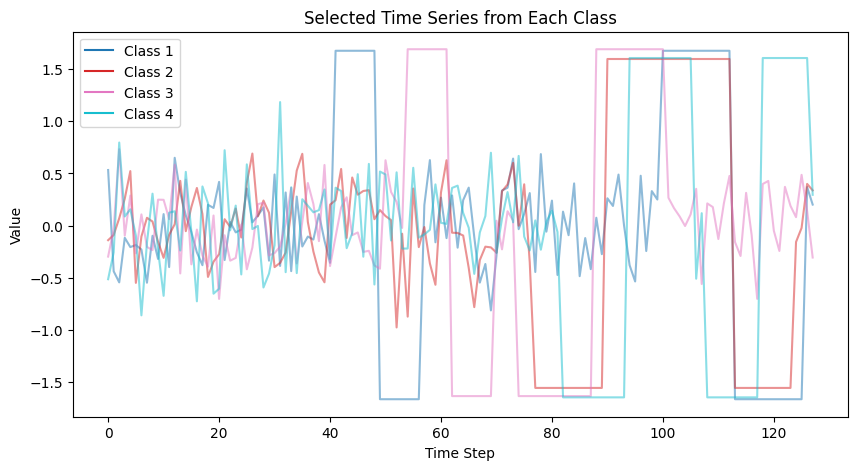

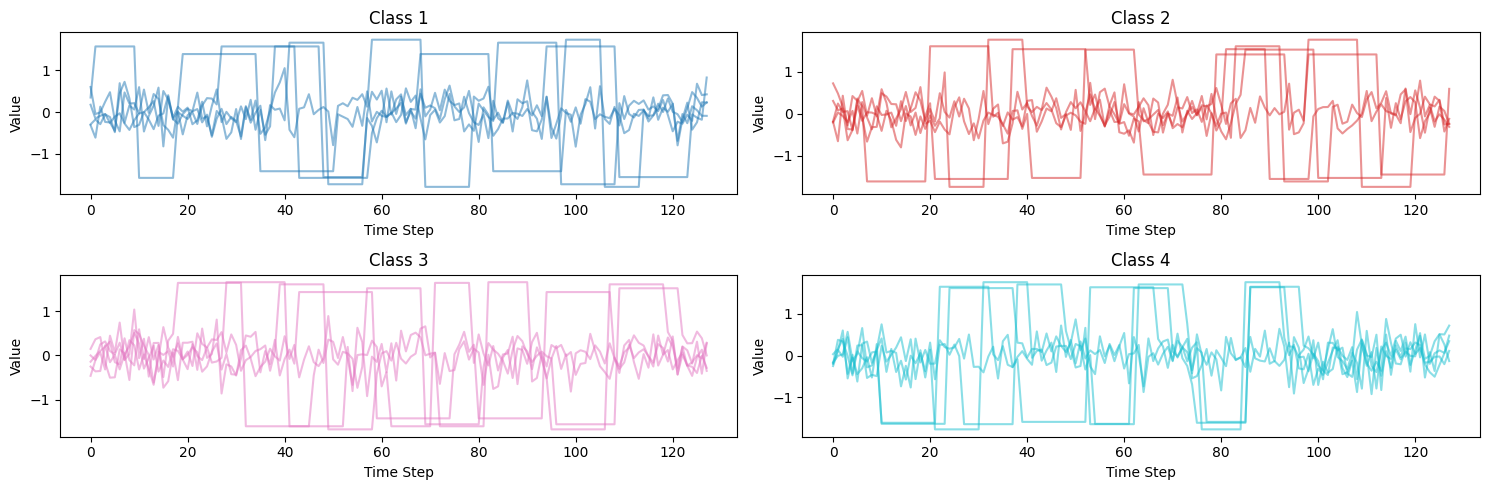

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_selected_classes(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    fig, ax = plt.subplots(figsize=(10, 5))

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Plot all selected samples for this class at once
        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        # Add a legend entry for this class
        ax.plot([], [], color=colors[idx], label=f'Class {cls}')

    ax.legend()
    plt.title('Selected Time Series from Each Class')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()


def plot_selected_classes_subplots(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    # Calculate the number of rows needed for subplots based on the number of classes
    num_rows = int(np.ceil(num_classes / 2))  # Adjust the denominator to control how many columns you want
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 2.5), squeeze=False)

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Determine which subplot to use
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]

        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        ax.set_title(f'Class {cls}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


plot_selected_classes(X_train, y_train, 1)
plot_selected_classes_subplots(X_train, y_train, 5)

### Question: Do we expect time-invariant methods to perform well on this dataset?

### Answer:
The time series for each class shows noisy curves with sudden level increases at different times. Each class has two curves: one with slight variations around 0 and one with more stable values but with sharp level shifts. When comparing the different classes, some patterns can be recognized in the time series with sharp level shifts but observed at different time steps. Therefore, time-shift invariant methods are expected to perform well in terms of clustering time series that are shifted across time. However, regarding predictions, the time-shift-sensitive methods are expected to perform better.

In this report, the following metrics are analyzed for the different methods:
-  Time-shift invariant method: soft-dtw
-  Time-shift sensitive method: euclidean

## Section 2 Comparing time-shift invariant and sensitive methods

The time-shift invariant and sensitive methods are compared on the following tasks:
* 2.1 clustering ;
* 2.2 supervised classification ;
* 2.3 forecasting ;





#### 2.1 TimeSeriesKMeans clustering with Euclidean distance metric and Soft-dtw distance metric

In [4]:
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tqdm.notebook import tqdm
import multiprocessing

# Function to evaluate clustering quality
def evaluate_clustering(X_train_scaled, params):
    n_clusters = params['n_clusters']
    metrics = params['metric']
    gamma = params['gamma']

    # Fit the model and predict clusters in one step
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrics, metric_params={"gamma": gamma}, n_jobs=multiprocessing.cpu_count() * 2 // 3, random_state=0)
    y_pred = km.fit_predict(X_train_scaled)

    # Compute the silhouette score
    score = silhouette_score(X_train_scaled, y_pred, metric=metrics, metric_params={"gamma": gamma})

    return {'n_clusters': n_clusters, 'gamma': gamma, 'score': score, 'metric': metrics}


#### For the grid search a random subset of the training set is taken because evaluating the different model configurations on the entire training set imposed a computational burden too large. This is mainly due to the heavier computational load for the soft-dtw compared to the Euclidean distance. In soft-dtw, the possible variations in the alignment of the sequences are taken into accounts.

In [6]:
# Preprocess the time series data
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)

sample_size = 200  # Adjust this value to your desired sample size
random_indices = np.random.choice(X_train_scaled.shape[0], sample_size, replace=False)
X_train_sample = X_train_scaled[random_indices]

# Define parameter grid for grid search
param_grid = [{'n_clusters': n_clusters, 'gamma': gamma, 'metric': metric} for n_clusters in range(2, 5) for gamma in [0.01, 0.1, 1, 10] for metric in ['euclidean', 'softdtw']]

# Perform grid search with tqdm progress bar using list comprehension
results = [evaluate_clustering(X_train_sample, params) for params in tqdm(param_grid, desc="Grid search progress")]


# Find the best parameters
best_params = max(results, key=lambda x: x['score'])
best_metric = best_params['metric']
best_n_clusters = best_params['n_clusters']
best_gamma = best_params['gamma']
best_score = best_params['score']

print(f"Best metric: {best_metric}")
print(f"Best number of clusters: {best_n_clusters}")
print(f"Best gamma for soft-DTW: {best_gamma}")
print(f"Best silhouette score: {best_score}")


Grid search progress:   0%|          | 0/24 [00:00<?, ?it/s]

Best metric: softdtw
Best number of clusters: 4
Best gamma for soft-DTW: 0.01
Best silhouette score: 0.6606876778056657


In [7]:
# Fit the final model with the best parameters
final_km = TimeSeriesKMeans(n_clusters=best_n_clusters,
                            metric=best_metric,
                            metric_params={"gamma": best_gamma},
                            verbose=1,
                            random_state=0)
final_km.fit(X_train_sample)



# Fit a final model with the best number of clusters according to the euclidean distance
euclidean_results = [result for result in results if result['metric'] == 'euclidean']
best_params_euclidean = max(euclidean_results, key=lambda x: x['score'])
best_n_clusters_euclidean = best_params_euclidean['n_clusters']

final_km_euclidean = TimeSeriesKMeans(n_clusters= best_n_clusters_euclidean,
                            metric='euclidean',
                            metric_params={"gamma": best_gamma},
                            verbose=1,
                            random_state=0)
final_km_euclidean.fit(X_train_sample)




# Plot the barycenters
# plt.figure(figsize=(10, 5))
# for i in range(best_n_clusters):
#     plt.plot(final_km.cluster_centers_[i], label=f'Barycenter {i+1}')
# plt.legend()
# plt.title('Barycenters of the clusters')
# plt.xlabel('Time Step')
# plt.ylabel('Value')
# plt.show()

164.878 --> 97.043 --> 96.416 --> 96.340 --> 96.357 --> 96.283 --> 96.299 --> 96.126 --> 96.080 --> 96.025 --> 96.005 --> 95.867 --> 95.918 --> 95.891 --> 95.875 --> 96.231 --> 96.275 --> 96.179 --> 96.192 --> 96.148 --> 96.162 --> 96.116 --> 96.139 --> 96.104 --> 96.115 --> 96.084 --> 96.105 --> 96.071 --> 96.076 --> 96.066 --> 96.100 --> 96.086 --> 96.090 --> 96.064 --> 96.132 --> 96.107 --> 96.144 --> 96.165 --> 96.153 --> 96.137 --> 96.143 --> 96.150 --> 96.146 --> 96.137 --> 96.143 --> 96.147 --> 96.148 --> 96.141 --> 96.147 --> 96.159 --> 
210.134 --> 116.632 --> 116.279 --> 116.094 --> 116.064 --> 116.018 --> 116.004 --> 116.004 --> 


TimeSeriesKMeans(metric_params={'gamma': 0.01}, n_clusters=2, random_state=0,
                 verbose=1)

### Visualization of the results for Soft-dtw and Euclidean centers and


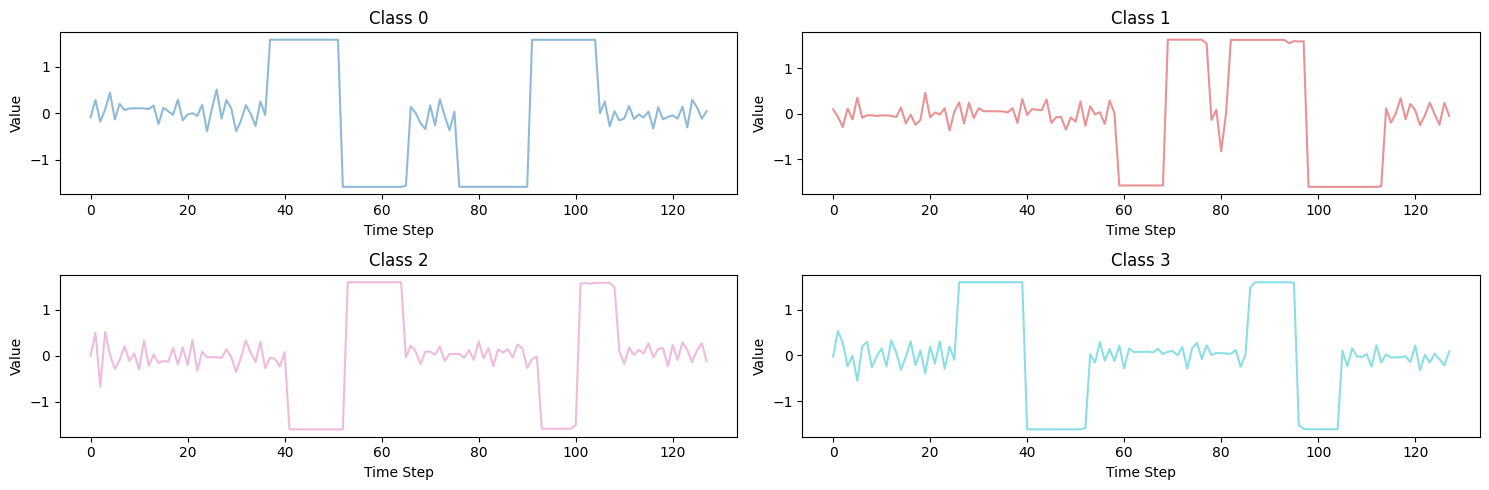

In [8]:
# Centers obtained by fitting a model with the best parameters as found with the soft-dtw metric
plot_selected_classes_subplots(final_km.cluster_centers_, list(range(final_km.n_clusters)), 1)

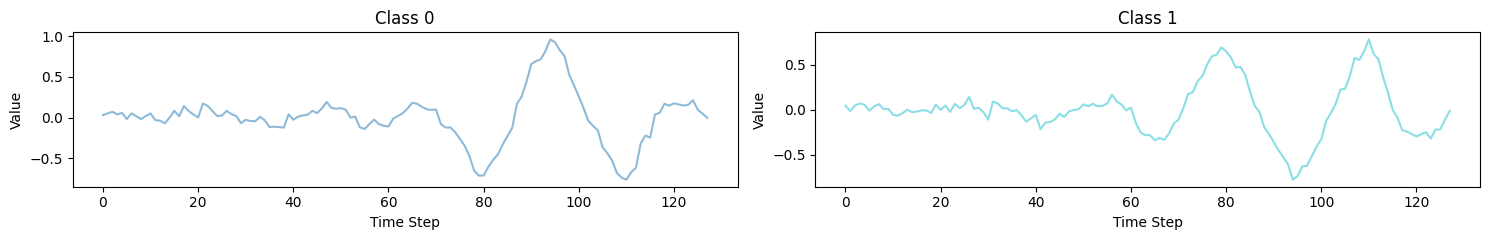

In [9]:
# Centers obtained by fitting a model with the best parameters as found with the Euclidean metric
plot_selected_classes_subplots(final_km_euclidean.cluster_centers_, list(range(final_km_euclidean.n_clusters)), 1)


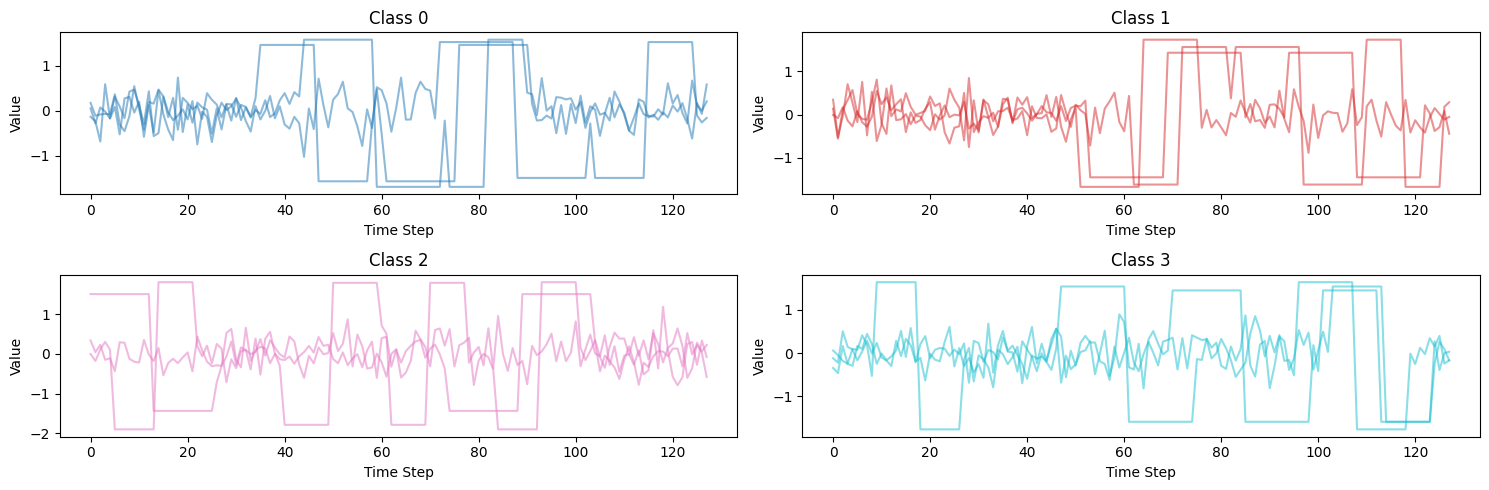

In [10]:
# Subset of the clustering as obtained with the best soft-dtw parameters
plot_selected_classes_subplots(X_train_sample, final_km.labels_, 3)

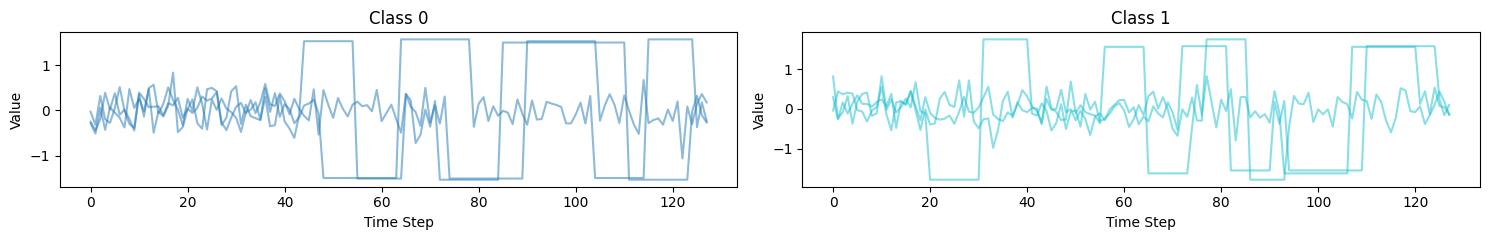

In [11]:
# Subset of the clustering as obtained with the Euclidean metric
plot_selected_classes_subplots(X_train_sample, final_km_euclidean.labels_, 3)

### Clustering Results and Conclusion

#### Results:
The "TwoPatterns" dataset was clustered using TimeSeriesKMeans algorithm with Euclidean and soft-DTW metrics.

For the soft-DTW metric:
The analysis algorithm identified four separate clusters, and the centers of each cluster corresponded to the shapes of the time series data within that cluster. This indicates that soft-DTW effectively captures the inherent patterns in the time series data, considering differences in sequence timing and phase shifts.

For the Euclidean distance metric:
The algorithm suggested two clusters as optimal, potentially due to its limitation in handling time-shifted sequences. The Euclidean metric focuses on point-wise distances and fails to account for the shape similarity between time series.

#### Conclusion:
Interpretation of the clustering results in terms of centers and number of clusters:

* In soft-dtw, the centers of the clusters resemble the shapes of the time series in those clusters, whereas the Euclidean distance does not resemble the shapes.

 The soft-dtw considers the shape of the time series, regardless of shifts in time. This leads to cluster centers that are more similar to the shapes of the time series within those clusters for soft-dtw. With Euclidean distance, the straight distance between points is measured (making it sensitive to temporal shifts).


* In soft-dtw, the correct number of clusters is identified, equal to 4. The Euclidean metric cannot correctly split the time series into 4 clusters but estimates that 2 clusters are the best. It tends to group time series that are close in overall distance but not necessarily in terms of shape similarity.

### 2.2 Supervised classification

#### **Experimental design**
For the classification of the time series, three architectures are examined which are:
* CNN with(out) attention
* LSTM with(out) attention
* Transformer

Important to note is that the training sample is 4 times smaller than the test sample. Therefore, it will be quite hard to train the models to fit the test data if the datasets show structural differences. The classifiers are trained using the CategoricalCrossEntropy loss and the performances of the classifiers are compared using the accuracy scores.
Additionally, we implemented some skip connections. These residual connections allow the input of a layer to be added to its output. It helps to mitigate the vanishing gradient problem. Residual connections enable the construction of deeper models without the risk of training stagnation due to the vanishing gradient.


CNNs, LSTMs, and Transformer models effectively evaluate time-series classification methods. Each architecture has unique characteristics that make it suitable for handling time-series data, strengths, and limitations in capturing temporal patterns and dependencies.

##### **CNN (Convolutional Neural Networks)**
- **Feature Extraction**: CNNs excel at automatically detecting important features. These networks can identify local patterns in the time series, such as trends and seasonality.
- **Hierarchical Pattern Learning**: The layered structure enables it to learn hierarchical representations. Early layers may detect simple patterns, while deeper layers can identify more complex sequences of patterns.
- **Efficiency**: CNNs are computationally efficient, especially for data where relevant features are local.

##### **LSTM (Long Short-Term Memory Networks)**
- **Temporal Dependencies**: LSTMs capture long-term dependencies, which is valuable for time series where the impact of a previous event may extend far into the future.
- **Sequence-to-Sequence Learning**: Unlike CNNs that treat the input data as fixed-size blocks, LSTMs process data in sequences suited for time series analysis where the order and timing of data points are critical.
- **Flexibility in Sequence Length**: LSTMs can (theoretically, but not with keras) handle variable-length input sequences.

##### **Why Apply Attention?**
- **Improved Interpretability**: Attention layers can provide insights into which parts are emphasized when making predictions, presenting a form of interpretability.
- **Adaptability**: Attention allows models to adapt their focus over different parts of the input data. It is beneficial when the relevance of specific data points can vary over time.

##### **Transformer**
- **Attention Mechanism**: The key innovation of Transformer models is the attention mechanism, which allows the model to weigh the importance of different parts of the input sequence when making predictions.
- **Parallel Processing**: Unlike LSTMs that process data sequentially, Transformers can process entire sequences simultaneously.
- **Global Perspective**: By evaluating the entire data sequence in unison, Transformers capture global dependencies, offering a comprehensive understanding that surpasses previous models' reach.


##### **Model Selection**
- **Local vs. Global Pattern Recognition**: CNNs might outperform other models when the dataset mainly features local, stationary patterns. On the other hand, Transformers might excel by understanding global context and relationships, potentially surpassing LSTMs in understanding longer temporal dependencies.
- **Flexibility and Efficiency**: While LSTMs provide a balanced approach with their adaptability to variable lengths, Transformers' efficiency and parallel processing capabilities present a interesting alternative for large datasets.

## CNN with(out) attention


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_cnn_attention_model(input_shape, num_categories, conv_configs, dense_units, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs

    for config in conv_configs:
        filters = config['filters']
        kernel_size = config['kernel_size']
        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)

        if config.get('attention'):
            # Reshape for attention if necessary. Attention requires the input shape as (batch_size, sequence, features).
            # After Conv1D and Pooling layers, the shape should already be compatible.
            query = value = x
            attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                            key_dim=config['attention']['key_dim'],
                                            dropout=dropout_rate)(query, value, value)
            x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
            x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm

def train_and_evaluate_model(create_model_func, configurations, X_train, y_train_cat, X_test, y_test_cat, model_type="Model"):
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)
    validation_accuracies = []
    histories = []

    for config in tqdm(configurations):
        model = create_model_func(X_train[0].shape, num_categories, **config)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=20, verbose=0, callbacks=[early_stopping])
        val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)
        validation_accuracies.append(val_accuracy)
        histories.append(history)

    # Select the best model
    best_index = validation_accuracies.index(max(validation_accuracies))
    best_config = configurations[best_index]

    print(f"[{model_type}] Best Model Configuration: {best_index}, Validation Accuracy: {max(validation_accuracies)}")

    # Retrain with the best configuration
    best_model = create_model_func(X_train[0].shape, num_categories, **best_config)
    best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    best_model.fit(X_train, y_train_cat, epochs=20, verbose=0)
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"[{model_type}] Test Set Accuracy: {test_accuracy}\n")

    return best_model, histories


In [ ]:
# Baseline CNN architecture (without attention and small kernel_size)
configs0 = [
    {'filters': 64, 'kernel_size': 5},
    {'filters': 128, 'kernel_size': 5},  
    {'filters': 64, 'kernel_size': 5}  
]

# First architecture: small kernel_size
configs1 = [
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 5},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]

# Second architecture: large kernel_size
configs2 = [
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 10},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
# Third architecture: large kernel_size
configs3 = [
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 5},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]

# Fourth architecture: large kernel_size
configs4 = [
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 10},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]

# CNN Configurations
cnn_configs = [
    {'conv_configs': configs0, 'dense_units': 64},
    {'conv_configs': configs1, 'dense_units': 64},
    {'conv_configs': configs2, 'dense_units': 128},
    {'conv_configs': configs3, 'dense_units': 64},
    {'conv_configs': configs4, 'dense_units': 128},
]

# Train and Evaluate Models
cnn_model, cnn_history = train_and_evaluate_model(create_cnn_attention_model, cnn_configs, X_train, y_train_cat, X_test, y_test_cat, "CNN")


  0%|          | 0/5 [00:00<?, ?it/s]

[CNN] Best Model Configuration: 2, Validation Accuracy: 1.0
[CNN] Test Set Accuracy: 0.9977499842643738



In [ ]:
import matplotlib.pyplot as plt

def plot_model_accuracies(histories, title_prefix=""):
    """
    Plots training and validation accuracies for each model configuration.

    Parameters:
    - histories: List of History objects from model training sessions.
    - title_prefix: String to prefix titles with, for distinguishing between model types.
    """
    num_histories = len(histories)
    fig, axs = plt.subplots(1, num_histories, figsize=(20, 5))

    if num_histories == 1:  # If only one history, make axs an array
        axs = [axs]

    for i, history in enumerate(histories):
        # Plot training and validation accuracy
        axs[i].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
        axs[i].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
        
        # Setting labels and titles
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Accuracy')
        axs[i].set_title(f'{title_prefix} Accuracy (Config {i})')
        axs[i].legend()

    # Adjust layout for better readability
    plt.tight_layout()

    # Display the plot
    plt.show()


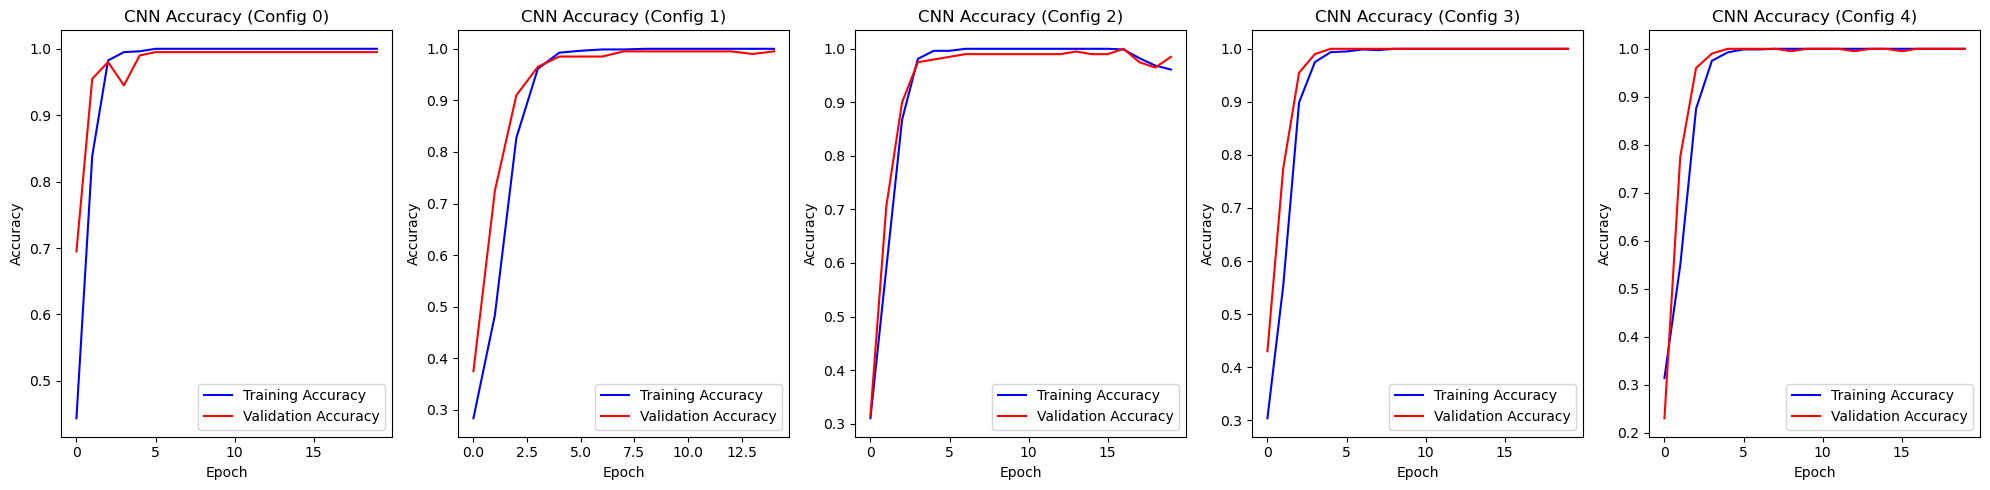

In [ ]:
plot_model_accuracies(cnn_history, title_prefix="CNN")

#### Results
The CNN models have shown excellent performance on the training and validation datasets with different configurations, achieving almost perfect accuracy. This demonstrates that the CNN models can effectively capture the local patterns present in the dataset. Overfitting is not a significant issue since the validation accuracy closely tracks the training accuracy, and the test accuracy is close to 1.


### LSTM with(out) attention

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_lstm_attention_model(input_shape, num_categories, lstm_configs, dense_units, dropout_rate=0.1):
    dense_units = dense_units
    inputs = Input(shape=input_shape)
    x = inputs

    for i, config in enumerate(lstm_configs):
        lstm_units = config['units']
        return_sequences = True if i < len(lstm_configs) - 1 else False
        x = LSTM(lstm_units, return_sequences=return_sequences)(x)

        if config.get('attention'):
            # Assuming the attention layer is applied after the LSTM layer
            if return_sequences:
                # MultiHeadAttention expects inputs as (batch_size, sequence_length, features),
                # which matches the output shape of LSTM with return_sequences=True
                query = value = x
                attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                                key_dim=config['attention']['key_dim'],
                                                dropout=dropout_rate)(query, value, value)
                x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
                x = Dropout(dropout_rate)(x)

    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# LSTM without attention
lstm_configs0 = [
    {'units': 64},
    {'units': 64},  
    {'units': 32}
]

lstm_configs1 = [
    {'units': 64, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'units': 64},  
    {'units': 32, 'attention': {'num_heads': 2, 'key_dim': 32}}  
]

lstm_configs2 = [
    {'units': 64, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'units': 64},  # LSTM layer without attention
    {'units': 32, 'attention': {'num_heads': 2, 'key_dim': 32}}  
]

# LSTM Configurations
lstm_configs = [
    {'lstm_configs': lstm_configs0, 'dense_units': 64},
    {'lstm_configs': lstm_configs1, 'dense_units': 64},
    {'lstm_configs': lstm_configs2, 'dense_units': 128},
]
lstm_model, lstm_history = train_and_evaluate_model(create_lstm_attention_model, lstm_configs, X_train, y_train_cat, X_test, y_test_cat, "LSTM")

  0%|          | 0/3 [00:00<?, ?it/s]

[LSTM] Best Model Configuration: 0, Validation Accuracy: 1.0
[LSTM] Test Set Accuracy: 0.9430000185966492



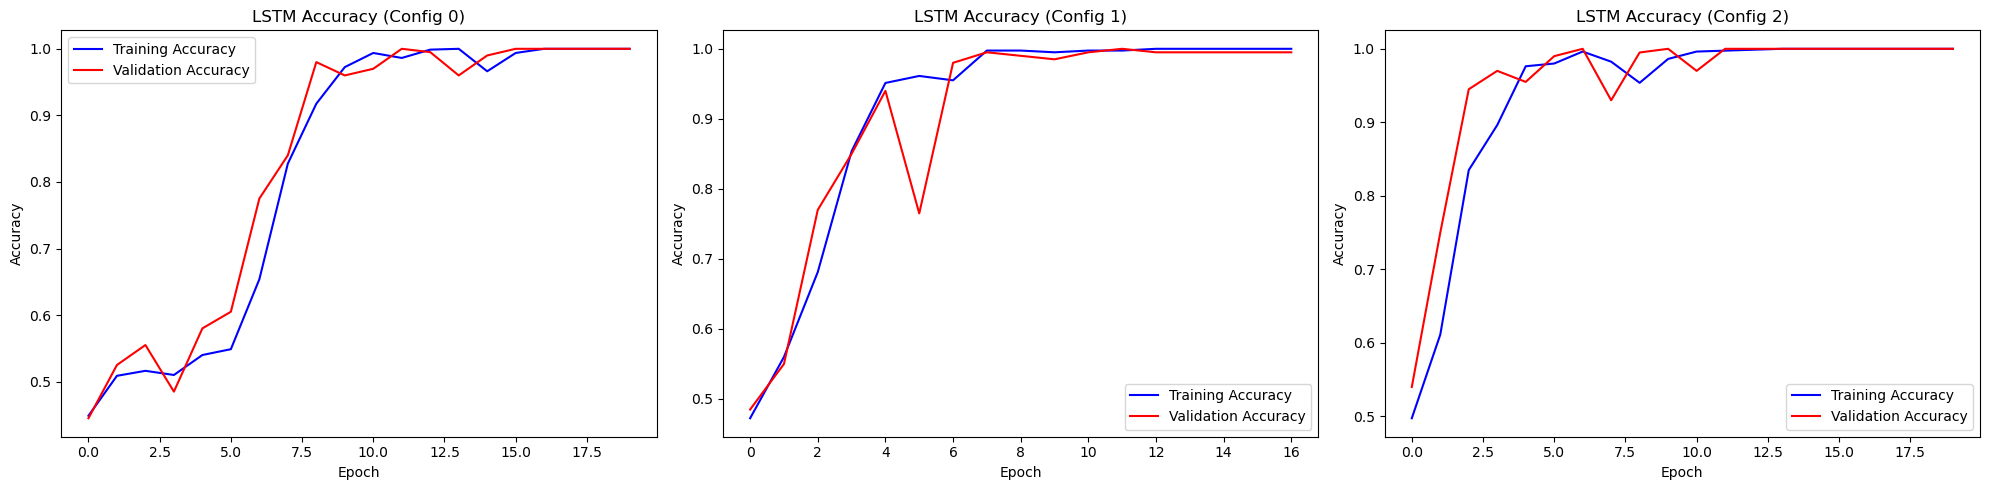

In [ ]:
plot_model_accuracies(lstm_history, title_prefix="LSTM")

#### Results
The LSTM models have shown good performance, with high accuracy rates in both training and validation. However, the validation accuracy tends to fluctuate more than the CNN models, indicating that the LSTM models may be more sensitive to the patterns in the validation set. Some overfitting has been observed, especially in Config 2, where the validation accuracy drops noticeably in the later epochs compared to the training accuracy. And here we see that the test accuracy farther from 1 than CNN, reinforcing the idea of slight overfitting.

### Transformer model

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
import keras

def create_transformer_model(input_shape, num_categories, num_layers, num_heads, d_model=64, dff=256, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    num_layers = num_layers
    num_heads = num_heads

    # Initial projection of input to the desired dimension (d_model)
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        # Multi-head attention
        attn_output = MultiHeadAttention(num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed-forward network
        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Pooling layer to reduce the sequence dimension
    pooled_output = GlobalAveragePooling1D()(x)

    # Output layer for classification
    outputs = Dense(num_categories, activation='softmax')(pooled_output)

    model = Model(inputs, outputs)
    return model

In [ ]:
# # Transformer Configurations
transformer_configs = [
    {'num_layers': 4, 'num_heads': 4, 'dff': 256},
    {'num_layers': 2, 'num_heads': 2, 'dff': 256},
    {'num_layers': 2, 'num_heads': 12, 'dff': 256},
]

transformer_model, transformer_history = train_and_evaluate_model(create_transformer_model, transformer_configs, X_train, y_train_cat, X_test, y_test_cat, "Transformer")

  0%|          | 0/3 [00:00<?, ?it/s]

[Transformer] Best Model Configuration: 2, Validation Accuracy: 0.3149999976158142
[Transformer] Test Set Accuracy: 0.2902500033378601



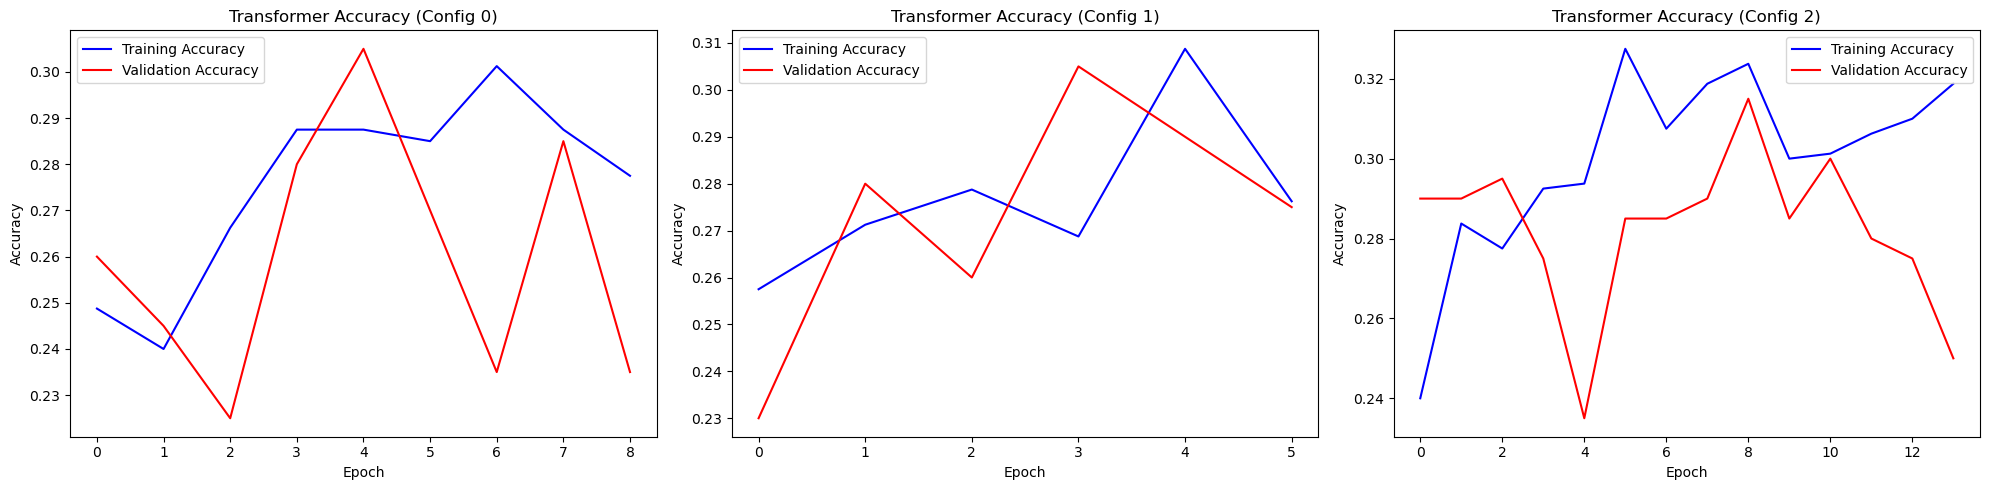

In [ ]:
plot_model_accuracies(transformer_history, title_prefix="Transformer")

#### Results 
The Transformer models display lower accuracy than the CNN and LSTM models. The training and validation lines also show significant fluctuation, indicating instability during training. This suggests that the Transformer models might not be suitable for the dataset or require further configuration tuning. The lower accuracy also indicates the presence of temporal dependencies in the dataset that the Transformer models are not effectively capturing without more advanced modeling techniques. Just as in the test accuracy, it is very poor.

### Conclusion

- **CNN Strengths**: CNN models performed well, implying that patterns in the dataset are well-captured by convolutional layers. Small kernel sizes and attention mechanisms didn't cause overfitting, indicating good balance between complexity and generalization.

- **LSTM Considerations**: While LSTM models are generally effective, the variability in validation accuracy suggests that some configurations might be too complex, capturing noise rather than the underlying pattern. Tuning the model complexity and regularization may help in achieving better generalization.

- **Transformer Adaptation**: The self-attention mechanism alone is insufficient for the time series classification task when using Transformers. The Transformers' performance is lower than expected. It may be necessary to incorporate advanced techniques such as positional encoding to capture the sequence order to improve results.

- **Model Selection**: After analyzing the data, it was found that Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks are the most suitable architectures for classification tasks associated with this particular dataset. However, it is important to consider the balance between model complexity and performance. CNNs offer the best balance as they provide high accuracy and stable training and validation curves. On the other hand, LSTMs are capable of capturing long-term dependencies, but they require careful tuning to avoid overfitting. It is recommended to explore other architectural choices to enhance the performance of Transformers.

## Section 2.3 Forecasting

For the assignment's forecasting, we explore LSTM and Transformer models to forecast the second half of the time series.

### Implementation Details

- **Encoding Context**: LSTM and Transformer models start by encoding the context (the first half of the time series). The LSTM processes each timestep sequentially, getting a representation of the sequence. In contrast, the Transformer uses self-attention to analyze the entire sequence simultaneously.
  
- **Forecasting Mechanism**:
  - **LSTM**: The LSTM model uses the `RepeatVector` to duplicate the encoded context for each forecasted timestep. This approach reuses the learned context, with the decoder sequentially generating the forecast based on this repeated context.
  - **Transformer**: The self-attention mechanisms allow the model to allocate focus dynamically across different segments. It improves the model's ability to capture complicated temporal patterns.

### Why Not CNN or Seq2Seq?
- **CNNs**: Convolutional Neural Networks (CNNs) are great at identifying patterns within a specific region. However, when forecasting tasks that require understanding long-term temporal dependencies, LSTM and Transformer models are preferred due to their capability of capturing both local and global dynamics of time series more effectively.

- **Seq2Seq Models**: While seq2seq models are powerful for various tasks such as sequence translation, they may not be necessary for simple forecasting. Furthermore, its implementation, especially with custom attention mechanisms, can be more complex and less straightforward in Keras than LSTM and Transformer models. This complexity, coupled with the direct forecasting nature of our task, makes LSTM and Transformer models more practical choices for this assignment.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_forecasting_data(X, t):
    """
    Prepares training data for forecasting the next T-t timesteps from the first t timesteps.

    Parameters:
    - X: numpy array of shape (n_series, T, n_features), original dataset.
    - t: int, number of timesteps to use as input.

    Returns:
    - X_input: Input data consisting of the first t timesteps from each series.
    - X_target: Target data consisting of the next T-t timesteps from each series.
    """
    X_input = X[:, :t, :]
    X_target = X[:, t:, :]

    return X_input, X_target

# Example usage
t = 64  # Number of timesteps given as input


X_train_input, X_train_target = prepare_forecasting_data(X_train, t)
X_test_input, X_test_target = prepare_forecasting_data(X_test, t)

print("Training input shape:", X_train_input.shape)
print("Training target shape:", X_train_target.shape)
print("Testing input shape:", X_test_input.shape)
print("Testing target shape:", X_test_target.shape)


Training input shape: (1000, 64, 1)
Training target shape: (1000, 64, 1)
Testing input shape: (4000, 64, 1)
Testing target shape: (4000, 64, 1)


In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout

def create_forecasting_lstm_model(input_shape, output_shape, lstm_units=[128, 128], dropout_rate=0.1, activation='relu'):
    """
    Create a forecasting LSTM model with configurable parameters.

    Parameters:
    - input_shape: Shape of the input data (time steps, features).
    - output_shape: Shape of the output data (time steps, features).
    - lstm_units: List of integers, specifying the number of units in each LSTM layer.
    - dropout_rate: Float, specifying the dropout rate for regularization.
    - activation: String, specifying the activation function for the Dense layers.
    """
    inputs = Input(shape=input_shape)

    x = inputs
    for i, units in enumerate(lstm_units):
        # Set return_sequences=True for all but the last LSTM layer
        return_sequences = i < len(lstm_units) - 1
        x = LSTM(units, return_sequences=return_sequences)(x)
        if return_sequences:  # Only apply dropout when returning sequences
            x = Dropout(dropout_rate)(x)

    # After the last LSTM layer, apply RepeatVector only if return_sequences was False
    repeated_encoding = RepeatVector(output_shape[0])(x)

    # Decoder part: Apply LSTM layers in reverse order as an example
    for units in reversed(lstm_units):
        x = LSTM(units, return_sequences=True)(repeated_encoding)  # Always return sequences in the decoder
        repeated_encoding = x  # Feed the output back as input to the next LSTM layer

    outputs = TimeDistributed(Dense(output_shape[1], activation=activation))(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
from tqdm.notebook import tqdm

def train_and_evaluate_forecasting_model(create_model_func, configurations, X_train, y_train, X_test, y_test, epochs=20, model_type="Model"):
    # Split the training data for validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    validation_losses = []
    validation_maes = []
    histories = []

    # Iterate over each configuration
    for config in tqdm(configurations):
        # Create and compile the model
        model = create_model_func(**config)
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train the model
        history = model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=epochs, verbose=0, callbacks=[early_stopping])
        val_mse, val_mae = model.evaluate(X_val_split, y_val_split, verbose=0)
        
        # Store the results
        validation_losses.append(val_mse)
        validation_maes.append(val_mae)
        histories.append(history)

    # Select the best model based on validation loss
    best_index = validation_losses.index(min(validation_losses))
    best_config = configurations[best_index]

    print(f"[{model_type}] Best Model Configuration: {best_index}, Validation MSE: {min(validation_losses)}, Validation MAE: {validation_maes[best_index]}")

    # Retrain with the best configuration
    best_model = create_model_func(**best_config)
    best_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    best_model.fit(X_train, y_train, epochs=epochs, verbose=0)
    test_mse, test_mae = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"[{model_type}] Test Set MSE: {test_mse}, Test Set MAE: {test_mae}\n")

    predictions = best_model.predict(X_test_input)
    return best_model, histories, predictions

In [ ]:
from matplotlib import pyplot as plt
def plot_model_performance(histories, title_prefix=""):
    """
    Plots training and validation loss (MSE) and metric (MAE) for each model configuration.

    Parameters:
    - histories: List of History objects from model training sessions.
    - title_prefix: String to prefix titles with, for distinguishing between model types.
    """
    num_histories = len(histories)
    fig, axs = plt.subplots(2, num_histories, figsize=(20, 10))  # Two rows for MSE and MAE

    for i, history in enumerate(histories):
        # Plot training and validation MSE
        axs[0, i].plot(history.history['loss'], label='Training MSE', color='blue')
        axs[0, i].plot(history.history['val_loss'], label='Validation MSE', color='red')
        axs[0, i].set_title(f'{title_prefix} MSE (Config {i})')
        axs[0, i].set_xlabel('Epoch')
        axs[0, i].set_ylabel('MSE')
        axs[0, i].legend()

        # Plot training and validation MAE
        axs[1, i].plot(history.history['mae'], label='Training MAE', color='blue')
        axs[1, i].plot(history.history['val_mae'], label='Validation MAE', color='red')
        axs[1, i].set_title(f'{title_prefix} MAE (Config {i})')
        axs[1, i].set_xlabel('Epoch')
        axs[1, i].set_ylabel('MAE')
        axs[1, i].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_predictions_vs_true(X_input, predictions, X_target, num_samples=5):
    """
    Plots comparison of predictions and true values for random samples in subplots.

    Parameters:
    - X_input: The input sequences.
    - predictions: The predicted sequences.
    - X_target: The actual target sequences.
    - num_samples: Number of random samples to plot, default and maximum is 5.
    """
    num_samples = min(num_samples, len(X_input), 5)  # Limit to 5 samples
    samples = np.random.choice(np.arange(len(X_input)), size=num_samples, replace=False)
    
    # Determine the number of rows needed (1 row for up to 5 samples)
    num_rows = 1
    num_cols = num_samples
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    
    if num_samples == 1:
        axs = [axs]  # Ensure axs is iterable for a single subplot
    
    for i, sample in enumerate(samples):
        axs[i].plot(list(range(64)), X_input[sample,:,0], label='Previous true values', color='skyblue')
        axs[i].plot(list(range(64, 128)), predictions[sample,:,0], label='Predictions', color='orange')
        axs[i].plot(list(range(64, 128)), X_target[sample,:,0], label='True Values', color='green')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Value')
        axs[i].set_title(f'Sample {sample}')
        axs[i].legend()
        
    plt.tight_layout()
    plt.show()


  0%|          | 0/3 [00:00<?, ?it/s]

[LSTM] Best Model Configuration: 2, Validation MSE: 1.109100103378296, Validation MAE: 0.8177729249000549
[LSTM] Test Set MSE: 1.1219574213027954, Test Set MAE: 0.8328185677528381

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


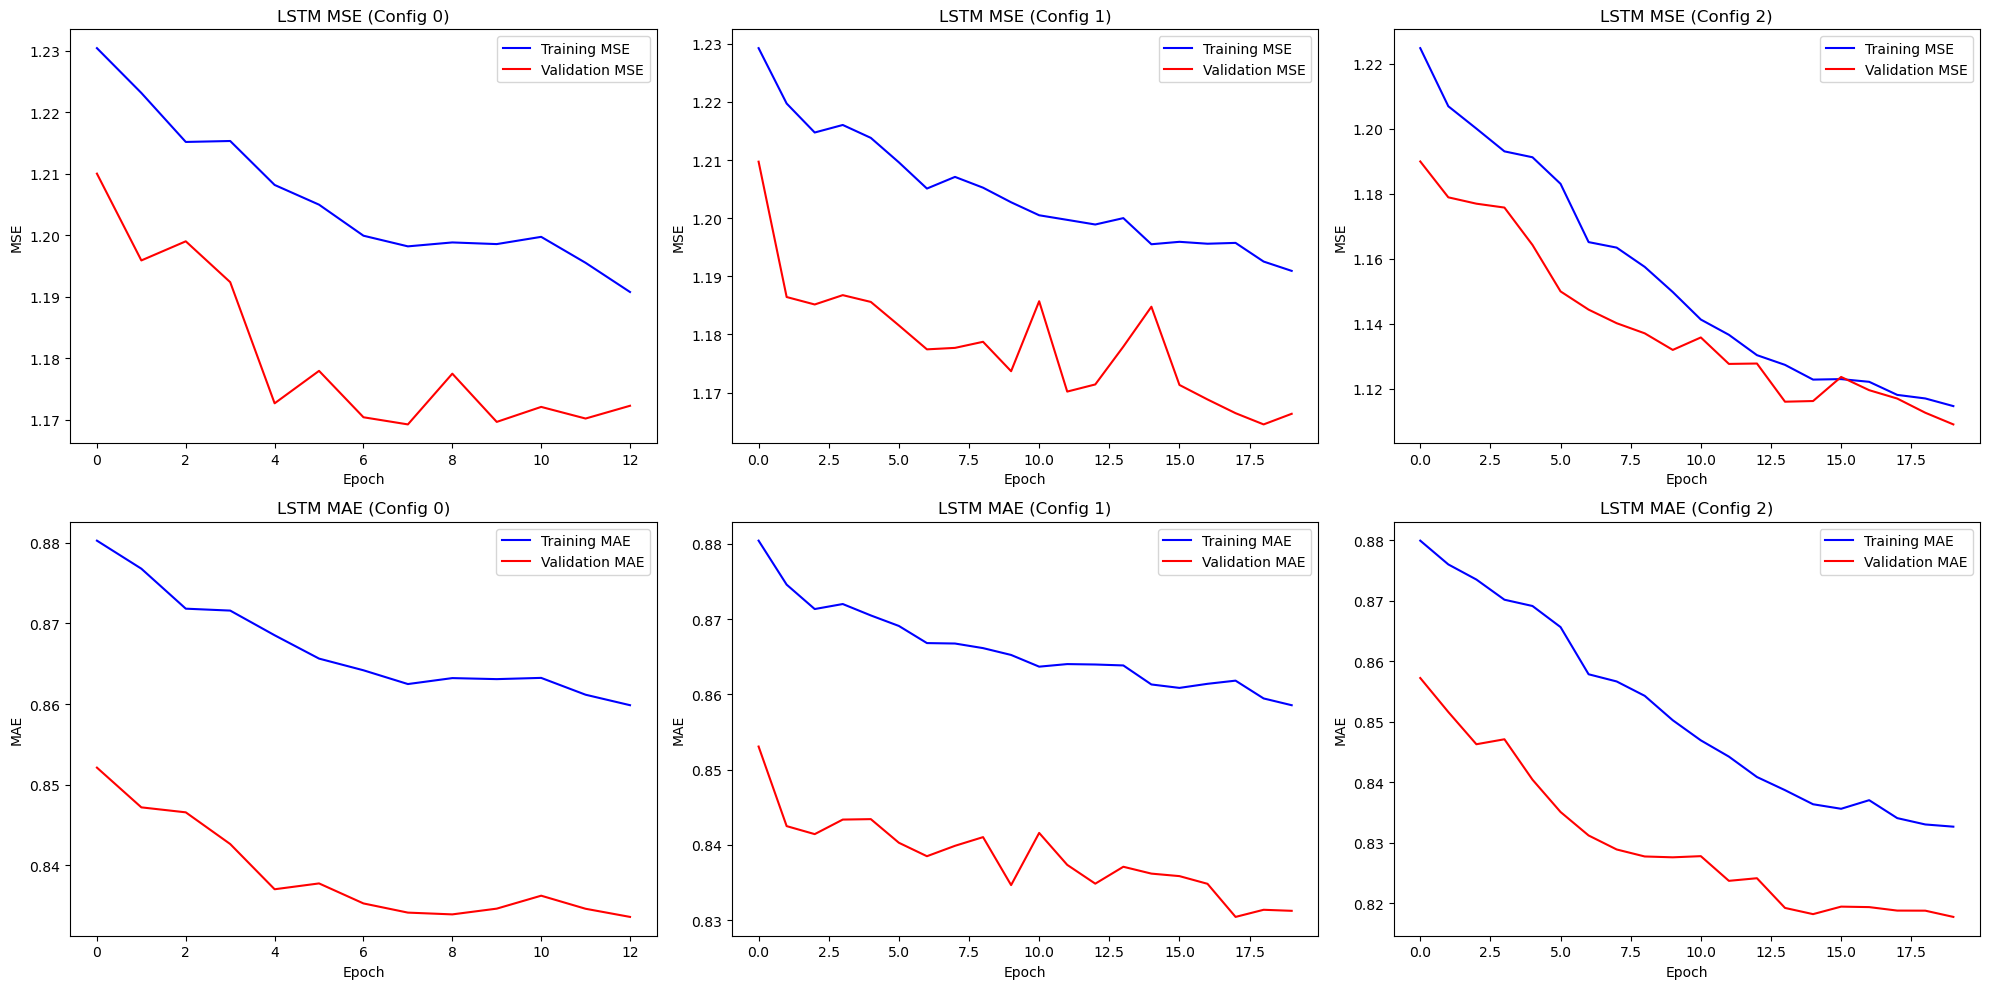

In [ ]:
lstm_configurations = [
    {'input_shape': X_train_input.shape[1:], 'output_shape': X_train_target.shape[1:], 'lstm_units': [64, 64], 'dropout_rate': 0.1, 'activation': 'relu'},
    {'input_shape': X_train_input.shape[1:], 'output_shape': X_train_target.shape[1:], 'lstm_units': [64, 64, 32], 'dropout_rate': 0.1, 'activation': 'relu'},
    {'input_shape': X_train_input.shape[1:], 'output_shape': X_train_target.shape[1:], 'lstm_units': [64, 64, 64], 'dropout_rate': 0.1, 'activation': 'tanh'},
]

# Train and evaluate LSTM models
lstm_model, lstm_histories, lstm_predictions = train_and_evaluate_forecasting_model(
    create_forecasting_lstm_model,
    lstm_configurations,
    X_train_input,
    X_train_target,
    X_test_input,
    X_test_target,
    epochs=20,
    model_type="LSTM"
)

# Plot the results or further analyze the best model as needed
plot_model_performance(lstm_histories, title_prefix="LSTM")

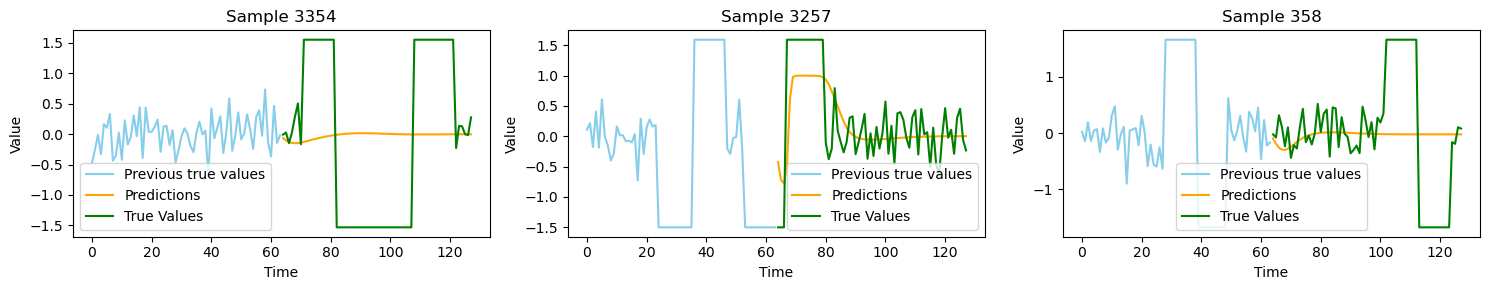

In [ ]:
plot_predictions_vs_true(X_test_input, lstm_predictions, X_test_target, num_samples=3)

#### Results
First of all, each graph has their own y-axis range. The results from the LSTM model demonstrate that, in some cases, the model can effectively track the overall trend of a time series. However, there are also instances where the model cannot capture sudden changes or more complex patterns. This indicates that the LSTM model can comprehend sequential data and retain information over a specific time frame, but it also highlights the difficulties in predicting more volatile sequences.

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, TimeDistributed

def create_forecasting_transformer_model(input_shape, num_layers, d_model, num_heads, dff, output_shape, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Use TimeDistributed to apply a Dense layer across each time step
    x = TimeDistributed(Dense(dff, activation='relu'))(x)
    
    # Final output layer to match the output sequence format
    outputs = TimeDistributed(Dense(output_shape[1]))(x)

    model = Model(inputs, outputs)
    return model


  0%|          | 0/3 [00:00<?, ?it/s]

W0000 00:00:1708725162.305090    2027 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[Transformer] Best Model Configuration: 0, Validation MSE: 1.20685875415802, Validation MAE: 0.8553038239479065
[Transformer] Test Set MSE: 1.209218978881836, Test Set MAE: 0.8729720115661621

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


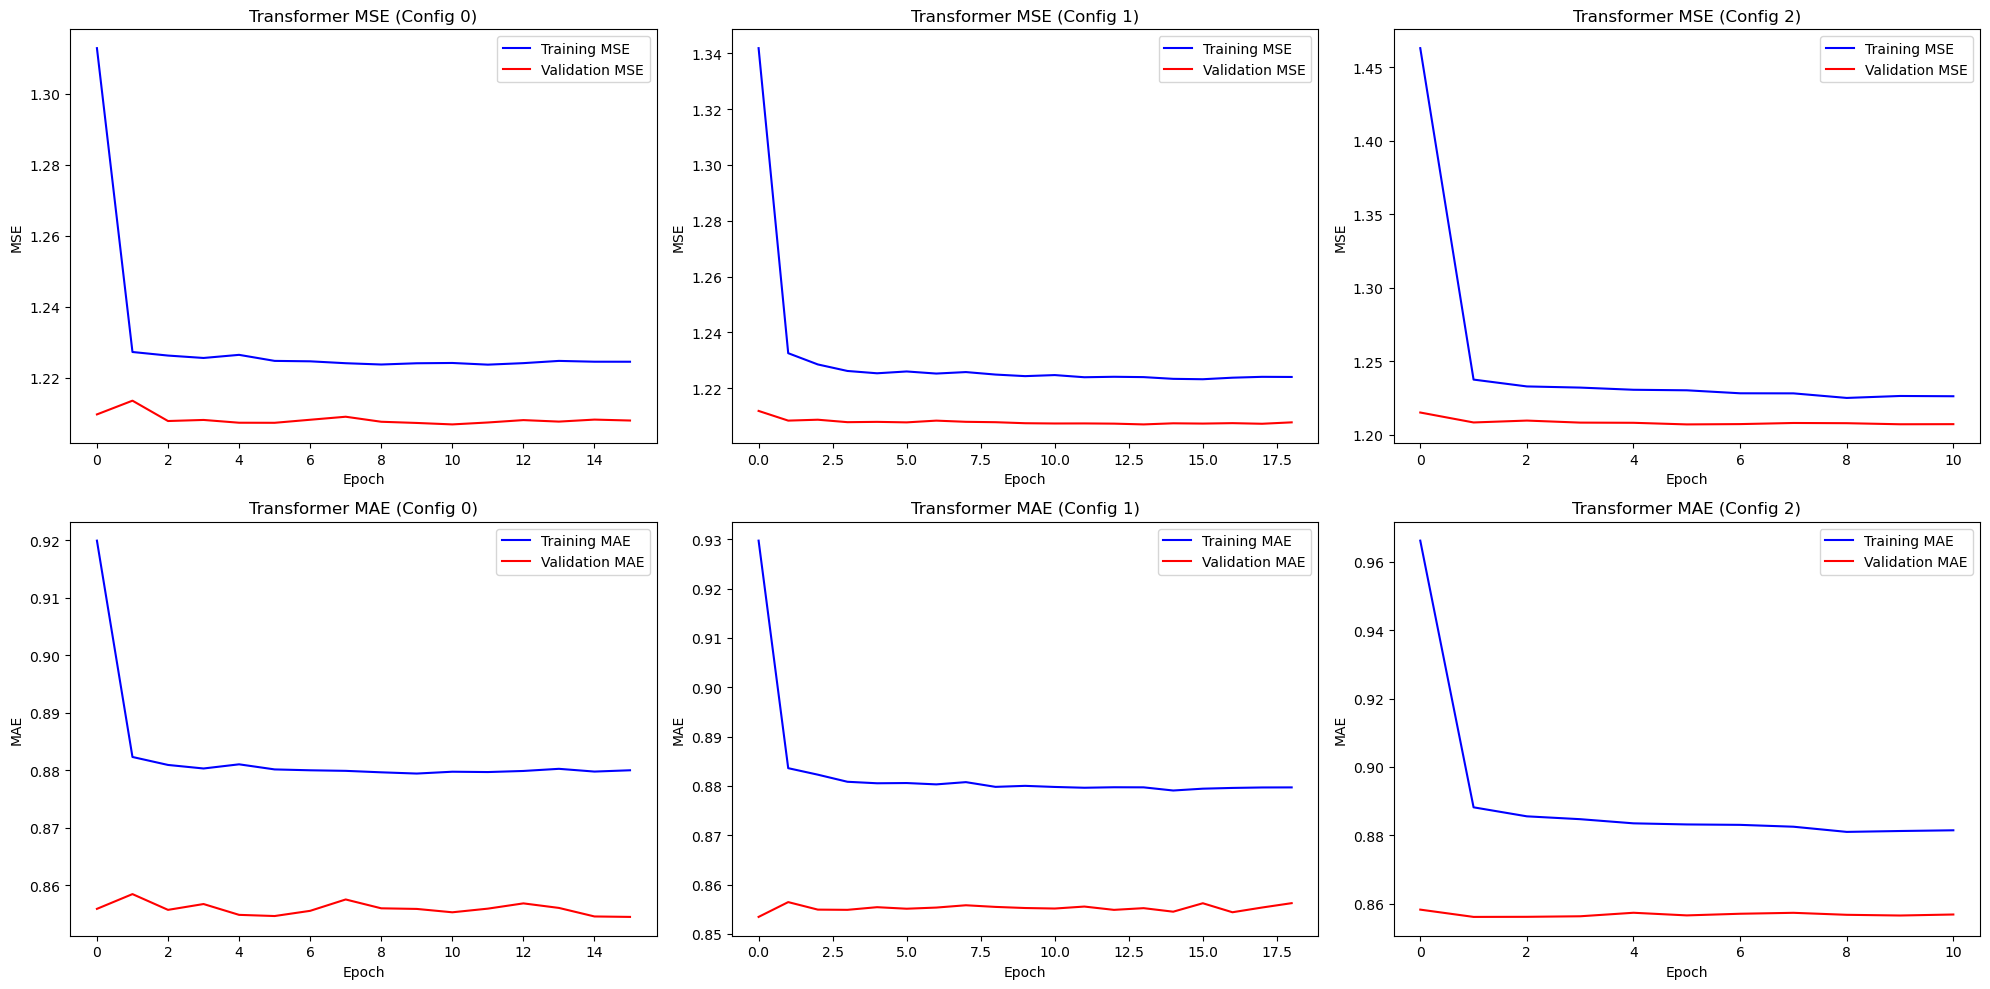

In [ ]:
transformer_configurations = [
    {'input_shape': X_train_input.shape[1:], 'num_layers': 3, 'd_model': 64, 'num_heads': 4, 'dff': 256, 'output_shape': X_train_target.shape[1:], 'dropout_rate': 0.1},
    {'input_shape': X_train_input.shape[1:], 'num_layers': 4, 'd_model': 64, 'num_heads': 2, 'dff': 128, 'output_shape': X_train_target.shape[1:], 'dropout_rate': 0.1},
    {'input_shape': X_train_input.shape[1:], 'num_layers': 2, 'd_model': 128, 'num_heads': 8, 'dff': 128, 'output_shape': X_train_target.shape[1:], 'dropout_rate': 0.1},
]

# Train and evaluate Transformer models
transformer_model, transformer_histories, transformer_predictions = train_and_evaluate_forecasting_model(
    create_forecasting_transformer_model,
    transformer_configurations,
    X_train_input,
    X_train_target,
    X_test_input,
    X_test_target,
    epochs=20,
    model_type="Transformer"
)

# Plot the results or further analyze the best model as needed
plot_model_performance(transformer_histories, title_prefix="Transformer")


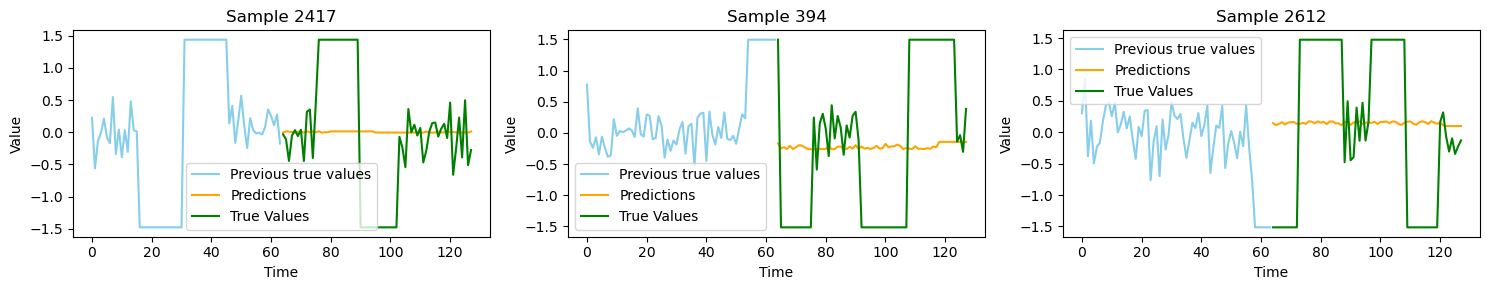

In [ ]:
plot_predictions_vs_true(X_test_input, transformer_predictions, X_test_target, num_samples=3)

#### Results
The Transformer model's results exhibit a similar pattern of performance. While the Transformer can see the trend (which is zero), its predictions do not always align closely with the actual values, particularly for samples with abrupt shifts. This suggests that the model, even with self-attention mechanisms, may require additional tuning or structural changes better to handle the intricacies of the time series data.

#### Conclusion & Limitations
Both models display proficiency in following the time series' general trend but need help with the finer details and rapid fluctuations. This is a common challenge in time series forecasting, where models must balance responsiveness to change and stability to avoid overfitting noise.

Due to time constraints, the extent of experimentation was limited. With more time, exploring a wider range of hyperparameters and model architectures would be beneficial. Additionally, employing techniques such as (cross-)validation could